# Calibration of Black and Scholes, Merton, Kou, Variance Gamma parameters
This notebook aims to find the optimal parameters of **Black-Scholes**, **Merton Jump Diffusion**, **Kou Jump Diffusion** and **Variance Gamma** models. To do so, we compute the european option prices using **closed formulas**, available for all the 4 models, and the **Fast Fourier Transform** for the VG model. Given these theoretical prices, the **implied volatilities** are computed comparing them with real market prices, minimizing their difference. Then we estimate the additional parameters of each model, using the python module `scipy.optimize`.

*reference: https://github.com/cantaro86/Financial-Models-Numerical-Methods/tree/master*


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.optimize as scpo
import sys
import time
import warnings
sys.path.append('C:/Users\ornel\PycharmProjects\Margin-Loans-Pricing/functions')
sys.path.append('C:/Users/ornel/PycharmProjects/Margin-Loans-Pricing/calibration')
warnings.simplefilter(action='ignore', category=FutureWarning)

from MERTONpricer import Merton_pricer
from BSpricer import BS_Pricer
from KOUpricer import Kou_pricer
from VGpricer import VG_pricer

random.seed(110)

Let's start retrieving historical prices for **european call** and **put** options starting from date **2016-01-20** and expiring **1 year** later. All the data have been collected from [OptionsDX](https://www.optionsdx.com/shop/) and preprocessed in `plainvanilla.py` module. Only options such that the moneyness
$$ K/S0 \in [0.75, 1.35] $$ have been selected.

In [2]:
df_put = pd.read_csv('../../data/TSLA/OPT16_TSLA_PUTS_75_135.csv')
print(f'NUM OF PUT OPTS: {df_put.shape[0]}')
print(df_put)


NUM OF PUT OPTS: 17
    QUOTE_DATE  UNDERLYING_LAST EXPIRE_DATE  P_BID  P_ASK  STRIKE     P_IV  \
0   2016-01-20            198.7  2017-01-20  18.55  19.94   150.0  0.53022   
1   2016-01-20            198.7  2017-01-20  20.40  21.31   155.0  0.52039   
2   2016-01-20            198.7  2017-01-20  22.20  23.35   160.0  0.51423   
3   2016-01-20            198.7  2017-01-20  24.55  25.80   165.0  0.51357   
4   2016-01-20            198.7  2017-01-20  26.70  28.05   170.0  0.50896   
5   2016-01-20            198.7  2017-01-20  27.70  30.36   175.0  0.49457   
6   2016-01-20            198.7  2017-01-20  30.25  32.75   180.0  0.49117   
7   2016-01-20            198.7  2017-01-20  33.89  35.30   185.0  0.49398   
8   2016-01-20            198.7  2017-01-20  36.25  38.45   190.0  0.49128   
9   2016-01-20            198.7  2017-01-20  39.16  40.60   195.0  0.48464   
10  2016-01-20            198.7  2017-01-20  42.10  43.70   200.0  0.48296   
11  2016-01-20            198.7  2017-01-20 

The dataframe **df_put** contains both 17 options without NaN values. Thus, we decide to use them all and look for the best parameters' estimation.

In [3]:
puts = df_put.sample(frac=1, replace=False).sort_index().reset_index(drop=True)

puts['P_Midpoint'] = abs(puts['P_BID'] + puts['P_ASK']) / 2
puts['P_Spread'] = puts['P_BID'] - puts['P_ASK']
put_prices = puts['P_Midpoint']
#puts.to_csv('../../data/TSLA/TSLA_puts.csv', index=False)


q = 0           # dividend yield
r = 0.03        # risk-free interest rate
sigma = 0.3     #volatility (variance of diffusion process)
S0 = puts.iloc[0]['UNDERLYING_LAST']
T = 1           # time-to-maturity
put_strikes = puts['STRIKE']      # array of K for put options
exercise = 'european'


The following code snippet initializes objects of class *BS_pricer*, *Merton_pricer*, *Kou_pricer*, *VG_pricer* with default values as parameters. Then it computes the theoretical put prices using closed formulas of each 4 models, with strike prices given by the *put_strikes* array. Additionally, we use the **Midpoint** price as the market price.

In [4]:
BS = BS_Pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=r, q = q, sigma=0.15, lambd=0.5, meanJ=-0.1, stdJ=0.1, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=0.15, lambd=0.5, p=0.6, eta1=12, eta2=5, exercise=exercise)
VG = VG_pricer(S0, K=None, ttm=T, r=r, q=q, sigma=0.15, theta=-0.2, nu=0.3, exercise=exercise)

The theoretical put prices with given parameters are computed below. 

In [5]:
put_th_prices = pd.DataFrame(columns=['Strike','Price', 'BlackScholes', 'Merton', 'Kou', 'VarianceGamma'])
put_th_prices['Strike'] = put_strikes
put_th_prices['Price'] = put_prices

for i, K in enumerate(put_strikes):
    bs = BS.closed_formula_put(K)
    mert = Merton.closed_formula_put(K)
    kou = Kou.closed_formula_put(K)
    vg = VG.closed_formula_put(K)
    put_th_prices.iloc[i, 2:] = [bs, mert, kou, vg]

print(f'Theoretical put options prices:')
print(put_th_prices)

Theoretical put options prices:
    Strike   Price BlackScholes     Merton        Kou VarianceGamma
0    150.0  19.245     3.929659   0.778865   1.482643      0.175632
1    155.0  20.855     4.913446   1.102963   1.841543      0.341115
2    160.0  22.775     6.050901   1.532207   2.294327      0.626665
3    165.0  25.175     7.349092   2.089948    2.86552      1.086948
4    170.0  27.375     8.813402   2.801224   3.582437      1.777988
5    175.0  29.030    10.447508   3.691752   4.473742      2.746041
6    180.0  31.500    12.253427   4.786674   5.567645      4.021194
7    185.0  34.595    14.231597   6.109153   6.889974      5.616897
8    190.0  37.350     16.38099   7.678992    8.46238        7.5326
9    195.0  39.880    18.699255   9.511419  10.300906      9.757354
10   200.0  42.900    21.182872  11.616195  12.415066     12.273247
11   210.0  48.820    26.627231  16.651981   17.47429     18.088484
12   220.0  55.230     32.66877  22.747208   23.58631     24.787991
13   230.0  62.5

## Implied volatility
The function belows implements $3$ methods to compute implied volatility: [Newton](https://en.wikipedia.org/wiki/Newton%27s_method) method, the [Bisection](https://en.wikipedia.org/wiki/Bisection_method) method and a more advanced one, named [Brent](https://en.wikipedia.org/wiki/Brent%27s_method) method. Apart from the initial guess, there is no substantial difference in the final result between **Newton** and **bisection** methods (*fsolve*). The **Implied Volatility** is that value $\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:
    $$ BS(S, K, T, r, \sigma) = P,  $$
where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk-free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.
   

In [6]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method='fsolve', disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method =='fsolve':
        X0 = [0.01, 0.2, 0.35, 7]        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if disp:
        return -1

The following code snippet computes the implied volatility of **put** options market prices with BS inversion, i.e. using the Black-Scholes formula on given market prices to find the best fitting $\sigma$ for each option contract.

Implied volatilities of market prices (puts):
S0 = 198.7
K = 150.0, IV = 0.5305
K = 155.0, IV = 0.5205
K = 160.0, IV = 0.5142
K = 165.0, IV = 0.514
K = 170.0, IV = 0.509
K = 175.0, IV = 0.4946


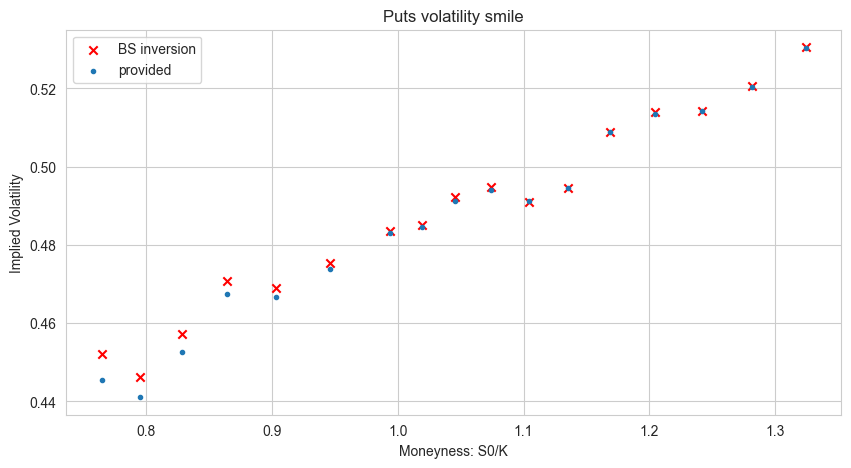

In [7]:
IV_market_p = []
for i in range(len(put_prices)):
    IV_market_p.append(implied_volatility(put_prices[i], S=S0, strike=put_strikes[i], t = T, rate=0.02, q = 0.08, type_o='put', method='fsolve'))

print(f'Implied volatilities of market prices (puts):\nS0 = {S0}')
for a,b in zip(put_strikes.head(6), IV_market_p[:6]):
    print(f'K = {a}, IV = {round(b, 4)}')

# Plot market implied volatilities w.r.t. log moneyness
x = (S0/put_strikes)
IV_filtered = [iv for iv in IV_market_p if iv != -1]
x_filtered = [log_m for iv, log_m in zip(IV_market_p, x) if iv != -1]
puts_filtered = [p_iv for iv, p_iv in zip(IV_market_p, puts['P_IV']) if iv != -1 ]

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.scatter(x_filtered, IV_filtered, marker='x', label='BS inversion', color='red')
ax1.scatter(x_filtered, puts_filtered, marker='.', label='provided')
ax1.set_xlabel('Moneyness: S0/K'); ax1.set_ylabel('Implied Volatility'); ax1.set_title('Puts volatility smile')
ax1.legend(); plt.show()


##  Weighted Calibration (call options)
Let's step now into the calibration of model parameters.
If we define $\Theta$ the set of parameters, the goal is to find the optimal parameters $\Theta^*$ that minimize the following objective function:
$$ \sum_{i=1}^{N} w_i \biggl( P_i - f(K_i|\Theta) \biggr)^2 $$
where $w_i$ are weights, usually defined as
$$ w_i = \frac{1}{\text {spread}_i^2 },$$ $P_i$ are the market prices and $f$ is the pricing function. In our case $f$ is given by **Merton** Jump Diffusion model, **Kou** Jump Diffusion model, or **Variance Gamma** process. To perform this optimization problem, many numerical methods can be used. In particular, we test two functions of `scipy.optimize`:
1. **curve_fit**, a least-squares curve fitting method which works with bounds. The default algorithm is [Trust Region Reflective (trf)](https://en.wikipedia.org/wiki/Trust_region). The [Levemberg-Marquadt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) has been tried as well, to test the optimization problem without setting boundaries, but the results don't make any sense.
2. **Least-Squares**, a constrained minimization problem which uses Trust region reflective method by default. This method is the most indicated to solve the non-linear least squares optimization problem of our purpose.
All the optimizations are carried out by initializing a starting point as the array $x_0 = [params]$ and setting feasible bounds.


In [8]:
put_spreads = puts['P_Spread']
p_weights = 1 / put_spreads**2

### Black and Scholes model
The only unknown parameter to calibrate in Black and Scholes model is the **implied volatility**, $\sigma$. Thus, we minimize the difference between the computed theoretical prices and the market prices of call options.

In [9]:
x0 = 0.5
bounds = [1e-5, 2]

def f_BlackScholes_puts(x, sigm):
    BS = BS_Pricer(S0=S0, K = x, ttm=T, r=r, q=0, sigma=sigm, exercise=exercise)
    return BS.closed_formula_put(x)

res1_puts = scpo.curve_fit(f_BlackScholes_puts, put_strikes, put_prices, p0 = x0, bounds=bounds, sigma=p_weights)
sigw_p = round(res1_puts[0][0],4)

In [10]:
def cost_function(x, strikes, mkt_prices):
    sigma = x
    BS = BS_Pricer(S0=S0, K = None, ttm=T, r=r, q=0, sigma=sigma, exercise=exercise)
    sq_err = np.sum( p_weights* (BS.closed_formula_put(strikes) - mkt_prices)**2)
    return sq_err

result_p = scpo.least_squares(cost_function, x0, args=(put_strikes, put_prices), bounds=bounds, method = 'trf', verbose=1)
opt_sigma_p = result_p.x[0]

`ftol` termination condition is satisfied.
Function evaluations 24, initial cost 5.3492e+04, final cost 1.0365e+00, first-order optimality 1.67e-03.


In [11]:
print('METHOD 1: CURVE_FIT (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {sigw_p} \t {round(sigw_p*100,2)}%')
print('METHOD 2: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatility from Calls [σ] = {opt_sigma_p} \t {round(opt_sigma_p*100,2)}%')

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatility from Calls [σ] = 0.5883 	 58.83%
METHOD 2: LEAST-SQUARES (trf)
> Calibrated Volatility from Calls [σ] = 0.5903386230196411 	 59.03%


In [12]:
puts_bs_params_tsla = opt_sigma_p
%store puts_bs_params_tsla

Stored 'puts_bs_params_tsla' (float64)


### Merton Jump Diffusion
The Merton Jump diffusion ones are the volatility $\sigma$, the Poisson rate of jumps $\lambda$, the mean rate of jump intensity $m$ and its variance rate $v$, assuming that the intensity of jumps follows a *Normal distribution*.


In [14]:
x0 = [0.2145,  0.8, -0.05,  0.01]  # initial guess: [σ, λ, m, v]
bounds = ( [0.01, 1e-2, -2, 1e-5], [0.9, 5, 2, 2] )

In [15]:
def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_put(x)

start1=time.time()
mert1 = scpo.curve_fit(f_Mert, put_strikes, put_prices, p0=x0, bounds=bounds, sigma=put_spreads)
end1=time.time()

mert_params1 = [round(p,4) for p in mert1[0][:4]]

##### Method 2. Least-squares

In [16]:
x0 = [0.2145,  0.8, -0.05,  0.01]  # initial guess: [σ, λ, m, v]
bounds = ( [0.01, 1e-2, -2, 1e-5], [0.9, 5, 2, 2] )

def cost_function(x, strikes, mkt_prices):
    sigma, lambd, meanJ, stdJ = x
    M = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
    sq_err = np.sum( p_weights*(M.closed_formula_put(strikes) - mkt_prices)**2)
    return sq_err

start2 = time.time()
mert2 = scpo.least_squares(cost_function, x0, args=(put_strikes, put_prices), bounds=bounds, method = 'trf', verbose=2)
end2 = time.time()

mert_params2 = [round(p,4) for p in mert2.x[:4]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2282e+07                                    7.44e+07    
       1              2         5.0268e+02      1.23e+07       7.87e-01       3.84e+04    
       2              6         3.6044e+02      1.42e+02       2.14e-02       5.18e+03    
       3              8         3.4105e+02      1.94e+01       3.81e-03       3.25e+03    
       4              9         3.2494e+02      1.61e+01       3.68e-03       3.00e+03    
       5             10         2.9443e+02      3.05e+01       7.25e-03       3.10e+03    
       6             11         2.4000e+02      5.44e+01       1.51e-02       2.40e+03    
       7             12         1.7341e+02      6.66e+01       2.71e-02       1.02e+04    
       8             14         1.4888e+02      2.45e+01       1.06e-02       1.91e+03    
       9             15         1.4121e+02      7.67e+00       6.44e-03       6.52e+03    

In [17]:
# print('WEIGHTED OPT: CURVE_FIT (trf)')
# print(f'> Calibrated Volatlity [σ] = {round(mert1[0][0],4)} \t {round(mert1[0][0]*100,2)}%')
# print('> Calibrated Jump intensity [λ] = ', round(mert1[0][1],2))
# print('> Calibrated Jump Mean = ', round(mert1[0][2],2))
# print('> Calibrated Jump St. dev.  = ', round(mert1[0][3],5))
# print(f'ELAPSED TIME: {end1-start1} sec')

print('\nMETHOD 1: LEAST SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {mert_params2[0]} \t {round(mert_params2[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(mert_params2[1],2))
print('> Calibrated Jump Mean = ', round(mert_params2[2],3))
print('> Calibrated Jump St. dev.  = ', round(mert_params2[3],3))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')


METHOD 1: LEAST SQUARES (trf)
> Calibrated Volatlity [σ] = 0.3917 	 39.17%
> Calibrated Jump intensity [λ] =  1.44
> Calibrated Jump Mean =  -0.062
> Calibrated Jump St. dev.  =  0.386
TIME ELAPSED:  53.95 sec


In [18]:
#print(mert_params1)
print(mert_params2)
puts_mert_params_tsla = mert_params2
%store puts_mert_params_tsla

[0.3917, 1.4429, -0.0621, 0.3856]
Stored 'puts_mert_params_tsla' (list)


### Kou Jump Diffusion


In [19]:
x0 = [0.1874, 0.75, 0.6, 10, 8] # initial guess: [σ, λ, p, η_1, η_2]
bounds = ( [1e-2, 1e-1, 0, 0, 0], [0.8, 4, 1, 15, 20] )

##### Method 1. TRF (Bounds)

In [18]:
# def f_Kou(x, sigma, lambd, p, eta1, eta2):
#     KouJD = Kou_pricer(S0=S0, K=x, ttm=T, r=r, sigma=sigma, lambd=lambd, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
#     return KouJD.closed_formula_put(x)
#
# start1 = time.time()
# kou1 = scpo.curve_fit(f_Kou, put_strikes, put_prices, p0=x0, bounds=bounds, sigma=p_weights)
# end1 = time.time()
#
# kou_params1 = [round(p,4) for p in kou1[0][:5]]

##### Method 2. LEAST SQUARES (With Bounds)

In [20]:
z# Define the objective function
def cost_function(x, strikes, mkt_prices):
    sigm, lamb, p, eta1, eta2 = x
    KOU = Kou_pricer(S0=S0, K=strikes, ttm=T, r=r, sigma=sigm, lambd=lamb, p=p, eta1=eta1, eta2=eta2, exercise=exercise)
    sq_err = np.sum(p_weights*(KOU.closed_formula_put(strikes) - mkt_prices)**2)
    return sq_err

start2=time.time()
kou2 = scpo.least_squares(cost_function, x0, args=(put_strikes, put_prices),  method='trf', bounds=bounds, verbose=2)
end2=time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1382e+07                                    5.43e+07    
       1              2         1.2011e+06      1.02e+07       1.89e-01       9.60e+06    
       2              3         1.4504e+05      1.06e+06       8.88e-02       1.64e+06    
       3              4         1.5467e+04      1.30e+05       5.34e-02       2.64e+05    
       4              5         1.4368e+03      1.40e+04       3.19e-02       3.96e+04    
       5              6         1.2072e+02      1.32e+03       1.85e-02       5.59e+03    
       6              7         1.0419e+01      1.10e+02       1.06e-02       7.44e+02    
       7              8         1.4310e+00      8.99e+00       6.69e-03       7.87e+01    
       8             10         1.0335e+00      3.98e-01       2.10e-03       1.62e+01    
       9             12         1.0116e+00      2.19e-02       5.24e-04       3.69e+00    

In [21]:
kou_params2 = [round(p,4) for p in kou2.x[:5]]

In [22]:
# print('WEIGHTED OPT: CURVE_FIT (trf)')
# print(f'> Calibrated Volatlity [σ] = {kou_params1[0]} \t {kou_params1[0] * 100}%')
# print('> Calibrated Jump intensity [λ] = ', kou_params1[1])
# print(f'> Calibrated Upward Jump probability [p] = {kou_params1[2]}, [q] = {round(1 - kou_params1[2], 2)}')
# print('> Calibrated Rate of Exp. 1  [η_1] = ', kou_params1[3])
# print('> Calibrated Rate of Exp. 2  [η_2] = ', kou_params1[4])
# print(f'TIME ELAPSED: {end1-start1} sec')

In [23]:
print('METHOD 2: Least-squares')
print(f'> Calibrated Volatlity [σ] = {round(kou_params2[0],4)} \t {round(kou_params2[0]*100,2)}%')
print('> Calibrated Jump intensity [λ] = ', round(kou_params2[1],2))
print(f'> Calibrated Upward Jump probability [p] = {round(kou_params2[2],2)}, [q] = {round(1-kou_params2[2],2)}')
print('> Calibrated Rate of Exp. 1  [η_1] = ', round(kou_params2[3],2))
print('> Calibrated Rate of Exp. 2  [η_2] = ', round(kou_params2[4],2))
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

METHOD 2: Least-squares
> Calibrated Volatlity [σ] = 0.5727 	 57.27%
> Calibrated Jump intensity [λ] =  0.86
> Calibrated Upward Jump probability [p] = 0.6, [q] = 0.4
> Calibrated Rate of Exp. 1  [η_1] =  9.97
> Calibrated Rate of Exp. 2  [η_2] =  7.98
TIME ELAPSED:  4000.0 sec


In [24]:
#print(kou_params1)
print(kou_params2)
puts_kou_params_tsla = kou_params2
%store puts_kou_params_tsla

[0.5727, 0.8597, 0.5985, 9.9668, 7.9809]
Stored 'puts_kou_params_tsla' (list)


### Variance Gamma


In [27]:
x0 = [0.18, -0.1, 0.4]   # initial guess: [σ, θ, v]
bounds = ( [1e-1, -1, 0], [0.7, 1.8, 3] )

##### Method 1. CURVE FIT (Bounds)

In [29]:
def f_VG(strikes, sigmax, thetax, nux):
    VGamma = VG_pricer(S0=S0, K=None, ttm=T, r=r, q=0, sigma=sigmax, theta=thetax, nu=nux, exercise='put')
    vg_prices = []
    for k in strikes:
        vg_prices.append(VGamma.closed_formula_put(k))
    return vg_prices

start1 = time.time()
vg1 = scpo.curve_fit(f_VG, put_strikes, put_prices, p0=x0, bounds=bounds, sigma=p_weights)
end1 = time.time()

vg_params1 = [round(p,4) for p in vg1[0][:3]]

##### Method 2. LEAST-SQUARES (Trust Region Reflective, Bounds)

In [31]:
def cost_function(x, strikes, mkt_prices):
    sigma, theta, nu = x
    VG = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
    prices = []
    for k in strikes:
        prices.append(VG.closed_formula_put(k))
    sq_err = np.sum(p_weights*(prices - mkt_prices)**2)
    return sq_err

start2=time.time()
vg2 = scpo.least_squares(cost_function, x0, args=(put_strikes, put_prices),  method='trf', bounds=bounds, verbose=2, loss='soft_l1')
end2=time.time()

vg_params2 = [round(p,4) for p in vg2.x[:3]]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.5755e+03                                    1.05e+04    
       1              2         5.8185e+02      4.99e+03       2.88e-01       2.81e+03    
       2              4         8.4083e+01      4.98e+02       1.52e-01       3.23e+03    
       3              6         7.2030e+01      1.21e+01       5.75e-02       6.94e+02    
       4              7         5.9170e+01      1.29e+01       8.54e-03       4.26e+02    
       5              8         5.1257e+01      7.91e+00       1.59e-02       4.18e+02    
       6             10         5.0625e+01      6.31e-01       7.69e-03       8.39e+01    
       7             11         4.9882e+01      7.43e-01       3.03e-03       1.82e+02    
       8             12         4.9322e+01      5.60e-01       6.75e-03       8.37e+01    
       9             13         4.8574e+01      7.49e-01       3.00e-03       1.76e+02    

In [32]:
print('WEIGHTED OPT: CURVE_FIT (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params1[0]}, \t {round(vg_params1[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params1[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params1[2])
print(f'TIME ELAPSED:  {round(end1-start1,2)} sec')

print('METHOD 1: LEAST-SQUARES (trf)')
print(f'> Calibrated Volatlity [σ] = {vg_params2[0]}, \t {round(vg_params2[0]*100,2)}%')
print('> Calibrated mean rate gamma process [θ] = ', vg_params2[1])
print('> Calibrated variance rate gamma process [v]= ', vg_params2[2])
print(f'TIME ELAPSED:  {round(end2-start2,2)} sec')

WEIGHTED OPT: CURVE_FIT (trf)
> Calibrated Volatlity [σ] = 0.6327, 	 63.27%
> Calibrated mean rate gamma process [θ] =  0.1262
> Calibrated variance rate gamma process [v]=  0.7386
TIME ELAPSED:  44.48 sec
METHOD 1: LEAST-SQUARES (trf)
> Calibrated Volatlity [σ] = 0.6289, 	 62.89%
> Calibrated mean rate gamma process [θ] =  0.173
> Calibrated variance rate gamma process [v]=  0.5591
TIME ELAPSED:  1520.81 sec


In [33]:
print(vg_params1)
print(vg_params2)
puts_vg_params_tsla = vg_params2
%store puts_vg_params_tsla

[0.6327, 0.1262, 0.7386]
[0.6289, 0.173, 0.5591]
Stored 'puts_vg_params_tsla' (list)


##### For when you don't want to recalibrate. Otherwise comment this cell

In [34]:
%store -r puts_bs_params_tsla
%store -r puts_mert_params_tsla
%store -r puts_kou_params_tsla
%store -r puts_vg_params_tsla

m_params = puts_mert_params_tsla
k_params = puts_kou_params_tsla
vg_params = puts_vg_params_tsla

### Reprice of options using calibrated parameters
Let's test our calibration results repricing initial market options. To do this we use both closed formulas and Monte Carlo pricing, to show that we achieve a very good parameters' estimation. 

In [35]:
days = 252
paths = 5000

put_calib_prices = pd.DataFrame({
    'STRIKE': puts['STRIKE'],    # array of K for call options
    'MKT_BID': puts['P_BID'],
    'MKT_MID': puts['P_Midpoint'],
    'MKT_ASK': puts['P_ASK'],

})
print(f'MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. \n\n{put_calib_prices}')

MARKET PRICES. STARTING DATE = 20-01-2016. EXPIRY = 1YEAR. 

    STRIKE  MKT_BID  MKT_MID  MKT_ASK
0    150.0    18.55   19.245    19.94
1    155.0    20.40   20.855    21.31
2    160.0    22.20   22.775    23.35
3    165.0    24.55   25.175    25.80
4    170.0    26.70   27.375    28.05
5    175.0    27.70   29.030    30.36
6    180.0    30.25   31.500    32.75
7    185.0    33.89   34.595    35.30
8    190.0    36.25   37.350    38.45
9    195.0    39.16   39.880    40.60
10   200.0    42.10   42.900    43.70
11   210.0    48.00   48.820    49.64
12   220.0    54.46   55.230    56.00
13   230.0    61.20   62.575    63.95
14   240.0    68.36   69.105    69.85
15   250.0    75.66   76.150    76.64
16   260.0    83.59   84.570    85.55


#### Merton Jump Diffusion model

In [36]:
#mert_params2 = [0.1267, 0.951, -0.1182, 0.2691]
sigma, lambd, meanJ, stdJ = m_params
MertonCAL = Merton_pricer(S0, None, T, r, q, sigma, lambd, meanJ, stdJ, exercise)
SMerton_CAL = MertonCAL.MertonPath(days, paths)

avg_payoffs = []
for K in put_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SMerton_CAL[-1]:
        payoffs.append(MertonCAL.payoff_put(K, St))
    avg_payoffs.append(np.mean(payoffs))

merton_mc_prices = np.zeros(len(put_calib_prices))
merton_cf_prices = np.zeros(len(put_calib_prices))

for index in range(len(put_calib_prices)):
    merton_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    merton_cf_prices[index] = MertonCAL.closed_formula_put(put_strikes[index])

put_calib_prices['MERTON MC'] = merton_mc_prices
put_calib_prices['MERTON CF'] = merton_cf_prices

print(put_calib_prices)

    STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC  MERTON CF
0    150.0    18.55   19.245    19.94  19.575544  19.908561
1    155.0    20.40   20.855    21.31  21.593028  21.938168
2    160.0    22.20   22.775    23.35  23.719326  24.073608
3    165.0    24.55   25.175    25.80  25.955227  26.313148
4    170.0    26.70   27.375    28.05  28.296963  28.654773
5    175.0    27.70   29.030    30.36  30.737417  31.096220
6    180.0    30.25   31.500    32.75  33.274356  33.635022
7    185.0    33.89   34.595    35.30  35.923291  36.268540
8    190.0    36.25   37.350    38.45  38.673100  38.994003
9    195.0    39.16   39.880    40.60  41.516456  41.808534
10   200.0    42.10   42.900    43.70  44.441446  44.709185
11   210.0    48.00   48.820    49.64  50.519422  50.756832
12   220.0    54.46   55.230    56.00  56.897334  57.112813
13   230.0    61.20   62.575    63.95  63.552903  63.753231
14   240.0    68.36   69.105    69.85  70.476580  70.654892
15   250.0    75.66   76.150    76.64  7

In [37]:
#kou_params2 = [0.1278, 0.948, 0.3549, 5.7153, 4.232]
sigma, lambd, p, eta1, eta2 = k_params
KouCAL = Kou_pricer(S0, None, T, r, sigma, lambd, p, eta1, eta2, exercise)
SKou_CAL = KouCAL.KouPath(days, paths)

avg_payoffs = []
for k in put_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SKou_CAL[-1]:
        payoffs.append(KouCAL.payoff_put(k, St))
    avg_payoffs.append(np.mean(payoffs))

kou_mc_prices = np.zeros(len(put_calib_prices))
kou_cf_prices = np.zeros(len(put_calib_prices))

for index in range(len(put_calib_prices)):
    kou_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    kou_cf_prices[index] = KouCAL.closed_formula_put(put_strikes[index])

put_calib_prices['KOU MC'] = kou_mc_prices
put_calib_prices['KOU CF'] = kou_cf_prices

print(put_calib_prices)

    STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC  MERTON CF     KOU MC  \
0    150.0    18.55   19.245    19.94  19.575544  19.908561  18.645257   
1    155.0    20.40   20.855    21.31  21.593028  21.938168  20.683797   
2    160.0    22.20   22.775    23.35  23.719326  24.073608  22.814653   
3    165.0    24.55   25.175    25.80  25.955227  26.313148  25.045068   
4    170.0    26.70   27.375    28.05  28.296963  28.654773  27.375245   
5    175.0    27.70   29.030    30.36  30.737417  31.096220  29.791837   
6    180.0    30.25   31.500    32.75  33.274356  33.635022  32.300281   
7    185.0    33.89   34.595    35.30  35.923291  36.268540  34.893071   
8    190.0    36.25   37.350    38.45  38.673100  38.994003  37.569267   
9    195.0    39.16   39.880    40.60  41.516456  41.808534  40.338895   
10   200.0    42.10   42.900    43.70  44.441446  44.709185  43.197084   
11   210.0    48.00   48.820    49.64  50.519422  50.756832  49.130050   
12   220.0    54.46   55.230    56.00 

In [38]:
# vg_params2 = [0.2442, 0.1983, 0.9451]
sigma, theta, nu = vg_params
VGCAL = VG_pricer(S0, None, T, r, q, sigma, theta, nu, exercise)
SVarGamma_CAL = VGCAL.VarianceGammaPath1(days, paths)

avg_payoffs = []
for K in put_strikes:
    payoffs = []        # stores here the payoff for each path, for a specific couple K1-K2
    for St in SVarGamma_CAL[-1]:
        payoffs.append(VGCAL.payoff_put(K, St))
    avg_payoffs.append(np.mean(payoffs))

vg_mc_prices = np.zeros(len(put_calib_prices))
vg_cf_prices = np.zeros(len(put_calib_prices))

for index in range(len(put_calib_prices)):
    vg_mc_prices[index] = np.exp(-r*T)* avg_payoffs[index]
    vg_cf_prices[index] = VGCAL.closed_formula_put(put_strikes[index])

put_calib_prices['VG MC'] = vg_mc_prices
put_calib_prices['VG CF'] = vg_cf_prices

print(put_calib_prices)

    STRIKE  MKT_BID  MKT_MID  MKT_ASK  MERTON MC  MERTON CF     KOU MC  \
0    150.0    18.55   19.245    19.94  19.575544  19.908561  18.645257   
1    155.0    20.40   20.855    21.31  21.593028  21.938168  20.683797   
2    160.0    22.20   22.775    23.35  23.719326  24.073608  22.814653   
3    165.0    24.55   25.175    25.80  25.955227  26.313148  25.045068   
4    170.0    26.70   27.375    28.05  28.296963  28.654773  27.375245   
5    175.0    27.70   29.030    30.36  30.737417  31.096220  29.791837   
6    180.0    30.25   31.500    32.75  33.274356  33.635022  32.300281   
7    185.0    33.89   34.595    35.30  35.923291  36.268540  34.893071   
8    190.0    36.25   37.350    38.45  38.673100  38.994003  37.569267   
9    195.0    39.16   39.880    40.60  41.516456  41.808534  40.338895   
10   200.0    42.10   42.900    43.70  44.441446  44.709185  43.197084   
11   210.0    48.00   48.820    49.64  50.519422  50.756832  49.130050   
12   220.0    54.46   55.230    56.00 

### Visualize calibration results
#### Closed Formulas Option pricing

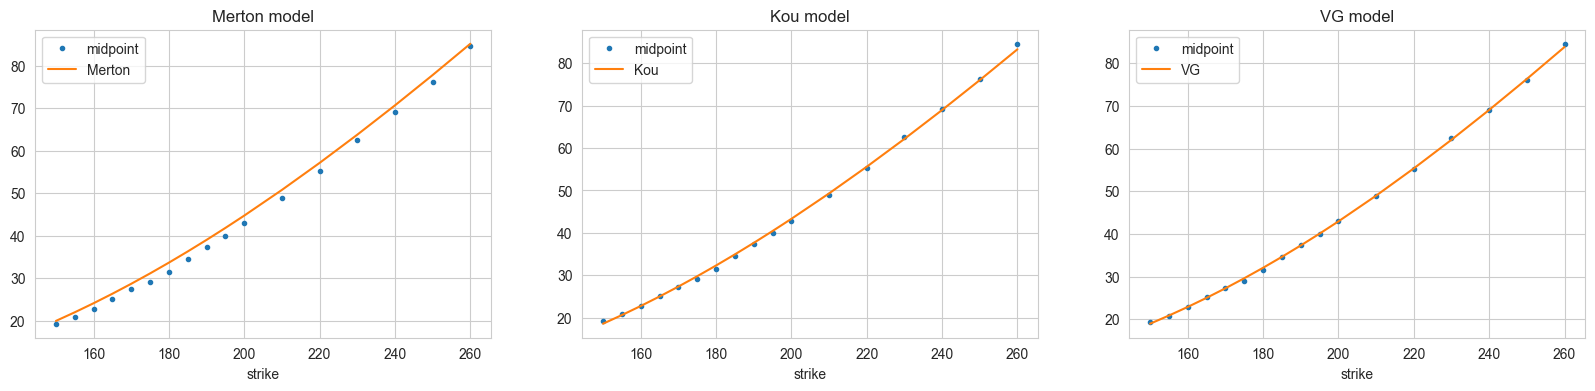

In [39]:
fig = plt.figure(figsize=(20, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(put_strikes, put_prices, ".", label="midpoint")
ax2.plot(put_strikes, put_prices, ".", label="midpoint")
ax3.plot(put_strikes, put_prices, ".", label="midpoint")
ax1.plot(put_strikes, merton_cf_prices, label="Merton")
ax2.plot(put_strikes, kou_cf_prices, label="Kou")
ax3.plot(put_strikes, vg_cf_prices, label="VG")
ax1.set_title("Merton model")
ax2.set_title("Kou model")
ax3.set_title("VG model")
ax1.set_xlabel("strike")
ax2.set_xlabel("strike")
ax3.set_xlabel("strike")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()


#### Monte Carlo option pricing

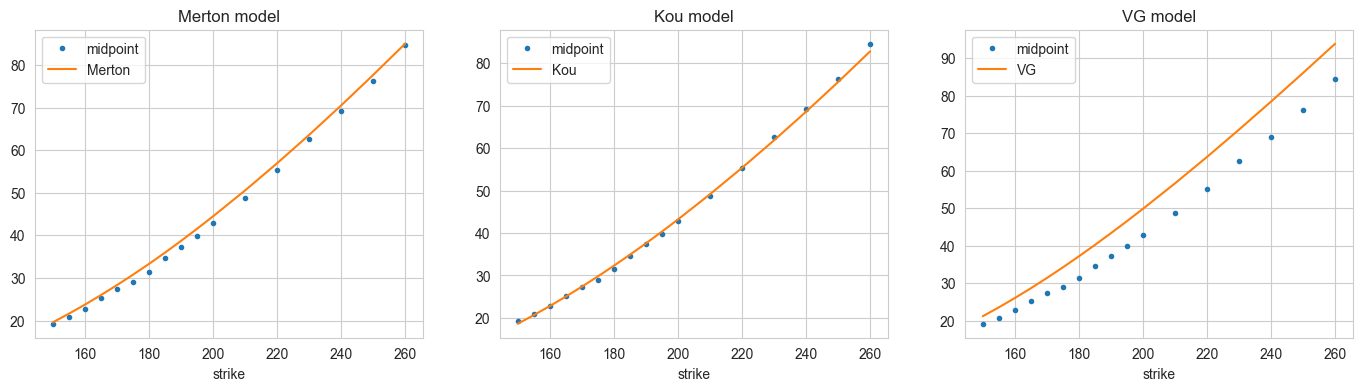

In [40]:
fig = plt.figure(figsize=(17, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.plot(put_strikes, put_prices, ".", label="midpoint")
ax2.plot(put_strikes, put_prices, ".", label="midpoint")
ax3.plot(put_strikes, put_prices, ".", label="midpoint")
ax1.plot(put_strikes, merton_mc_prices, label="Merton")
ax2.plot(put_strikes, kou_mc_prices, label="Kou")
ax3.plot(put_strikes, vg_mc_prices, label="VG")
ax1.set_title("Merton model")
ax2.set_title("Kou model")
ax3.set_title("VG model")
ax1.set_xlabel("strike")
ax2.set_xlabel("strike")
ax3.set_xlabel("strike")
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

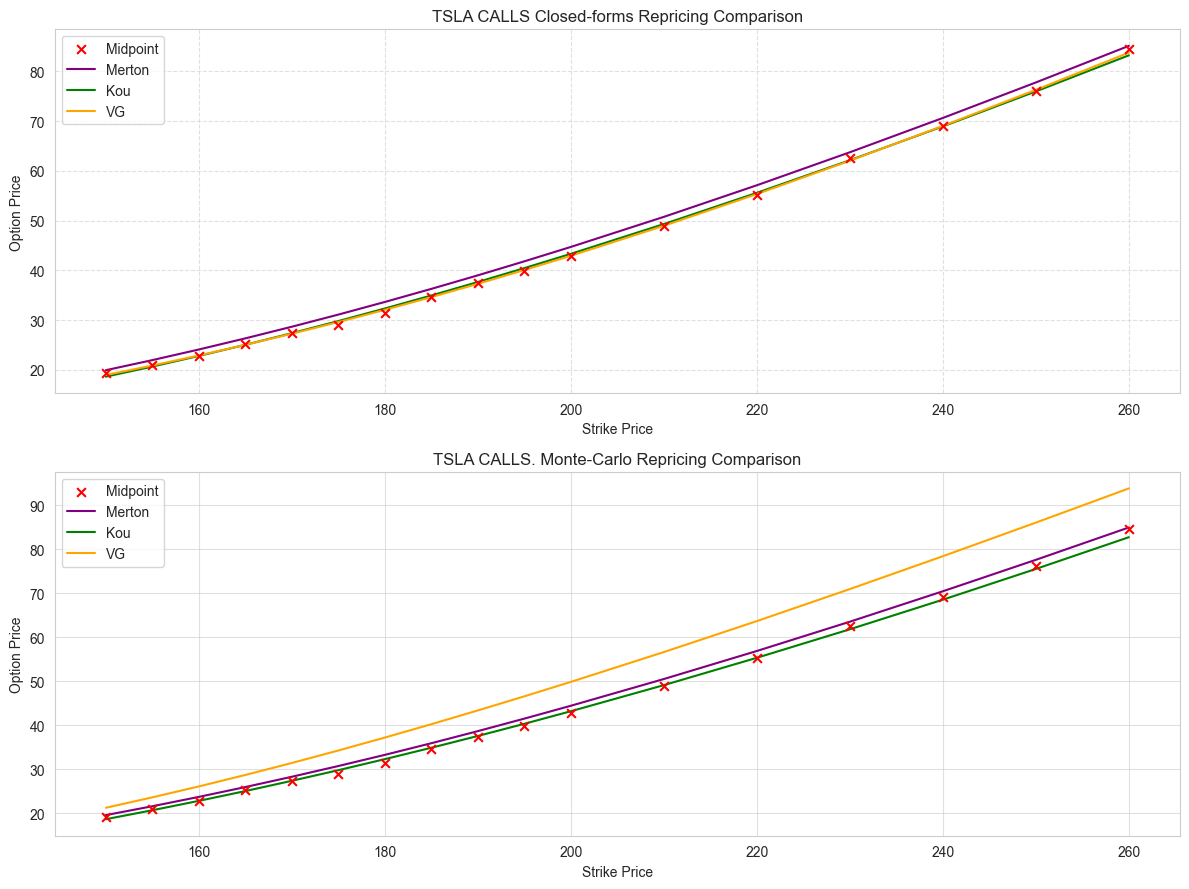

In [41]:
fig, ax = plt.subplots(nrows = 2, figsize=(12,9))

# Plot the first subplot (Merton model)
ax[0].scatter(put_strikes, put_prices, marker='x', color='red', label="Midpoint", s=40, zorder=2)
ax[0].plot(put_strikes, merton_cf_prices, label="Merton", color="purple", zorder=1)

# Plot the second subplot (Kou model)
ax[0].plot(put_strikes, kou_cf_prices, label="Kou", color="green", zorder=1)

# Plot the third subplot (VG model)
ax[0].plot(put_strikes, vg_cf_prices, label="VG", color="orange", zorder=1)

ax[0].set_title("TSLA CALLS Closed-forms Repricing Comparison")
ax[0].set_xlabel("Strike Price")
ax[0].set_ylabel("Option Price")
ax[0].legend()
ax[0].grid(True, linestyle="--", alpha=0.6)


# Plot the first subplot (Merton model)
ax[1].scatter(put_strikes, put_prices, marker='x', color='red', label="Midpoint", s=40, zorder=2)
ax[1].plot(put_strikes, merton_mc_prices, label="Merton", color="purple", zorder=1)

# Plot the second subplot (Kou model)
ax[1].plot(put_strikes, kou_mc_prices, label="Kou", color="green", zorder=1)

# Plot the third subplot (VG model)
ax[1].plot(put_strikes, vg_mc_prices, label="VG", color="orange", zorder=1)

ax[1].set_title("TSLA CALLS. Monte-Carlo Repricing Comparison")
ax[1].set_xlabel("Strike Price")
ax[1].set_ylabel("Option Price")
ax[1].legend()
plt.grid(True, linestyle="-", alpha=0.6)
plt.tight_layout()
plt.show()